# Similarity-Based Constraint Score For Feature Selection Notebook

In this notebook, you will find a comprehensive summary of the project, detailing key steps undertaken and presenting results obtained during the implementation of our innovative constraint score.



In [2]:
%cd /Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS
import numpy as np
import pandas as pd
import sklearn.datasets as skd
from sklearn.preprocessing import StandardScaler
from c_scores import *
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as Knn
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# warnings.filterwarnings("default")

/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/fabiogadegbeku/Desktop/M1_DS/projet_recherche/Similarity-Based-CS


### Wine dataset

In [3]:
# Loding the wine data
WineDB = skd.load_wine()
X = WineDB.data
y = WineDB.target

X_wine = np.concatenate((X, y.reshape(-1, 1)), axis=1)
X_train_wine , X_test_wine = split_dataset(X_wine)

Rep number:   0%|          | 0/100 [00:00<?, ?it/s]

Rep number: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


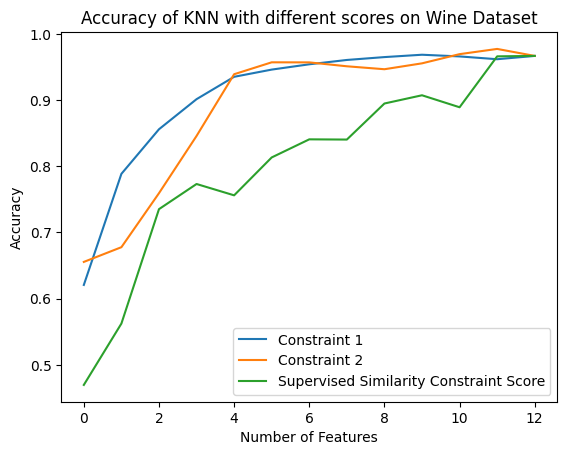

In [4]:
scores = [constraint_score_1,constraint_score_2,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_wine, X_test_wine,100,3)
accuracy_constraint_1 = scores_accuracy[0]
accuracy_constraint_2 = scores_accuracy[1]
accuracy_supervised_similarity_constraint = scores_accuracy[2]



plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_2, label = 'Constraint 2')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Supervised Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Wine Dataset')

plt.legend()


In [5]:
auc_constraint_1 = auc_score(accuracy_constraint_1)
auc_constraint_2 = auc_score(accuracy_constraint_2)
auc_similarity_constraint = auc_score(accuracy_supervised_similarity_constraint)

print('AUC of Constraint 1: ', auc_constraint_1)
print('AUC of Constraint 4: ', auc_constraint_2)
print('AUC of Similarity Constraint Score: ', auc_similarity_constraint)

AUC of Constraint 1:  0.8458504273504269
AUC of Constraint 4:  0.8266495726495717
AUC of Similarity Constraint Score:  0.745897435897436


Rep number: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


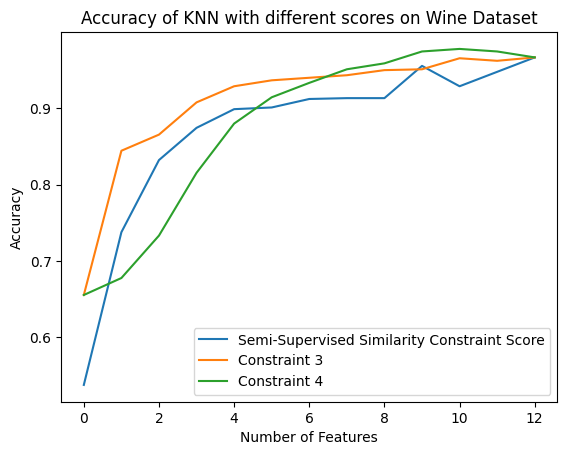

In [6]:
scores = [semi_supervised_similarity_constraint_score,constraint_score_3,constraint_score_4]
scores_accuracy = plot_accuracy(scores, X_train_wine, X_test_wine,10,3)
accuracy_semi_supervised_similarity_constraint = scores_accuracy[0]
accuracy_constraint_3 = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]



plt.plot(accuracy_semi_supervised_similarity_constraint, label = 'Semi-Supervised Similarity Constraint Score')
plt.plot(accuracy_constraint_3, label = 'Constraint 3')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Wine Dataset')

plt.legend()


In [6]:
scores = [laplacian_score,constraint_score_1,constraint_score_2,supervised_similarity_constraint_score]
R = rank_matrix(scores,X_train_wine,5,3)

In [7]:
R_matrix_laplacian = R[0]
R_matrix_constraint_1 = R[1]
R_matrix_constraint_2 = R[2]
R_matrix_similarity_constraint = R[3]

In [8]:
print(R_matrix_constraint_1)
print(R_matrix_constraint_2)
print(R_matrix_similarity_constraint)

[[12.  6. 11.  2.  0.  9.  5.  7.  8. 10.  4.  1.  3.]
 [12.  6.  1. 11.  4. 10.  8.  3.  9.  2.  0.  7.  5.]
 [11.  6.  9.  5. 12. 10.  8.  0.  1.  7.  3.  2.  4.]
 [12.  6.  0. 11.  9.  2. 10.  5.  7.  1.  4.  3.  8.]
 [ 4.  6. 12.  5.  0.  9. 11.  7.  1.  8. 10.  2.  3.]]
[[12.  4.  2.  0.  3.  6. 11. 10.  7.  9.  5.  8.  1.]
 [12.  4.  3.  2.  0.  6. 11. 10.  7.  9.  8.  5.  1.]
 [12.  4.  3. 11.  0.  2.  6. 10.  9.  5.  7.  8.  1.]
 [12.  4.  0.  2.  3.  6. 11. 10.  9.  7.  5.  8.  1.]
 [12.  4.  0.  3.  2.  6. 11. 10.  5.  9.  7.  8.  1.]]
[[ 2.  3.  4.  5.  1.  6.  7.  8.  9. 10. 11. 12.  0.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.  0.]
 [ 2.  3.  4.  5.  1.  6.  7.  8.  9. 10. 11. 12.  0.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.  0.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.  0.]]


## OTHER DATA SETS ( Vehicule,Image Segmentation,WBCD,Ionosphere,Libras Movement,CNAE-9)

### Vehicules

In [7]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_vehicle_silhouettes = fetch_ucirepo(id=149)

# data (as pandas dataframes)
X = statlog_vehicle_silhouettes.data.features
y = statlog_vehicle_silhouettes.data.targets

# pandas to numpy
X = X.values
y = y.values


# get classes and their counts
classes, counts = np.unique(y, return_counts=True)

ind_204 = np.where(y == '204')[0]

# remove class 204
X = np.delete(X, ind_204, axis=0)
y = np.delete(y, ind_204)

# encode the classes to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


data_vehicles = np.concatenate((X,y[np.newaxis].T), axis=1)
data_vehicles = split_dataset(data_vehicles)[0]

X_train_vehicle, X_test_vehicle = split_dataset(data_vehicles)

Rep number: 100%|██████████| 10/10 [03:04<00:00, 18.48s/it]


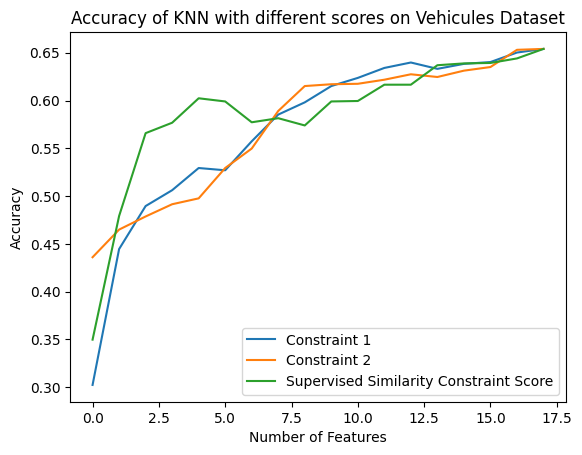

In [8]:
scores = [constraint_score_1,constraint_score_2,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_vehicle, X_test_vehicle,10,3)
accuracy_constraint_1 = scores_accuracy[0]
accuracy_constraint_2 = scores_accuracy[1]
accuracy_supervised_similarity_constraint = scores_accuracy[2]

plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_2, label = 'Constraint 2')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Supervised Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Vehicules Dataset')

plt.legend()

In [9]:
auc_constraint_1 = auc_score(accuracy_constraint_1)
auc_constraint_2 = auc_score(accuracy_constraint_2)
auc_similarity_constraint = auc_score(accuracy_supervised_similarity_constraint)

print('AUC of Constraint 1: ', auc_constraint_1)
print('AUC of Constraint 2: ', auc_constraint_2)
print('AUC of Similarity Constraint Score: ', auc_similarity_constraint)

AUC of Constraint 1:  0.5439178515007899
AUC of Constraint 2:  0.5438388625592417
AUC of Similarity Constraint Score:  0.5582675092153765


Rep number: 100%|██████████| 10/10 [03:36<00:00, 21.68s/it]


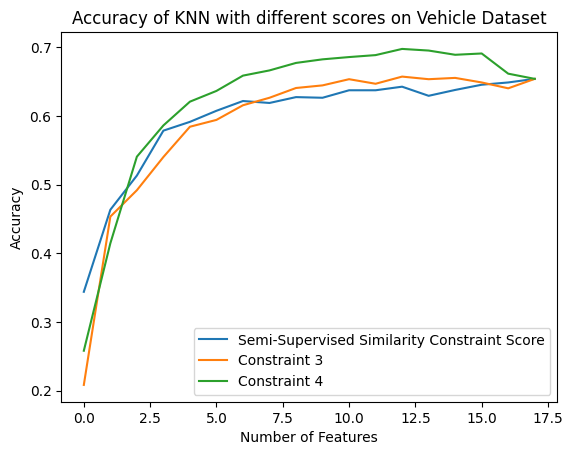

In [10]:
scores = [semi_supervised_similarity_constraint_score,constraint_score_3,constraint_score_4]
scores_accuracy = plot_accuracy(scores, X_train_vehicle, X_test_vehicle,10,3)
accuracy_semi_supervised_similarity_constraint = scores_accuracy[0]
accuracy_constraint_3 = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]



plt.plot(accuracy_semi_supervised_similarity_constraint, label = 'Semi-Supervised Similarity Constraint Score')
plt.plot(accuracy_constraint_3, label = 'Constraint 3')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Vehicle Dataset')

plt.legend()

In [11]:
auc_constraint_3 = auc_score(accuracy_constraint_3)
auc_constraint_4 = auc_score(accuracy_constraint_4)
auc_semi_similarity_constraint = auc_score(accuracy_semi_supervised_similarity_constraint)


print('AUC of Semi-Supervised Similarity Constraint Score: ', auc_semi_similarity_constraint)
print('AUC of Constraint 3: ', auc_constraint_3)
print('AUC of Constraint 4: ', auc_constraint_4)


AUC of Semi-Supervised Similarity Constraint Score:  0.5681937862032648
AUC of Constraint 3:  0.5655081621906266
AUC of Constraint 4:  0.5971695629278567


### Image Segmentation Dataset

In [12]:
image_segmentation = pd.read_csv('./sim_based_cs/data/segmentation.csv')
image_segmentation.head()
# get the features and the target in numpy format
X = image_segmentation.iloc[:, 1:].values
y = image_segmentation.iloc[:,0].values

# encode the classes to integers
le = LabelEncoder()
y = le.fit_transform(y)

data_segmentation = np.concatenate((X,y[np.newaxis].T), axis=1)

data_segmentation_reduced, _ = split_dataset(data_segmentation)

X_train_image_seg, X_test_image_seg = split_dataset(data_segmentation_reduced)

Rep number: 100%|██████████| 1/1 [02:26<00:00, 146.09s/it]


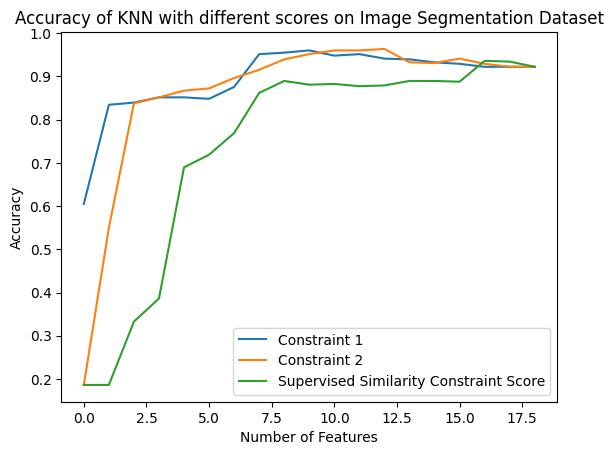

In [14]:
scores = [constraint_score_1,constraint_score_2,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_image_seg, X_test_image_seg,1,3)
accuracy_constraint_1 = scores_accuracy[0]
accuracy_constraint_2 = scores_accuracy[1]
accuracy_supervised_similarity_constraint = scores_accuracy[2]


plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_2, label = 'Constraint 2')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Supervised Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Image Segmentation Dataset')

plt.legend()

In [16]:
auc_constraint_1 = auc_score(accuracy_constraint_1)
auc_constraint_2 = auc_score(accuracy_constraint_2)
auc_similarity_constraint = auc_score(accuracy_supervised_similarity_constraint)

print('AUC of Constraint 1: ', auc_constraint_1)
print('AUC of Constraint 2: ', auc_constraint_2)
print('AUC of Similarity Constraint Score: ', auc_similarity_constraint)

AUC of Constraint 1:  0.8537205081669692
AUC of Constraint 2:  0.8304446460980036
AUC of Similarity Constraint Score:  0.7077586206896552


Rep number: 100%|██████████| 1/1 [06:04<00:00, 364.78s/it]


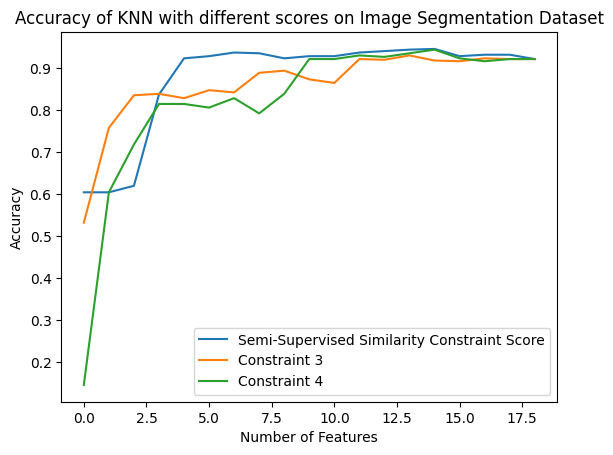

In [17]:
scores = [semi_supervised_similarity_constraint_score,constraint_score_3,constraint_score_4]
scores_accuracy = plot_accuracy(scores, X_train_image_seg, X_test_image_seg,1,3)
accuracy_semi_supervised_similarity_constraint = scores_accuracy[0]
accuracy_constraint_3 = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]



plt.plot(accuracy_semi_supervised_similarity_constraint, label = 'Semi-Supervised Similarity Constraint Score')
plt.plot(accuracy_constraint_3, label = 'Constraint 3')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Image Segmentation Dataset')

plt.legend()

In [18]:
auc_constraint_3 = auc_score(accuracy_constraint_3)
auc_constraint_4 = auc_score(accuracy_constraint_4)
auc_semi_similarity_constraint = auc_score(accuracy_semi_supervised_similarity_constraint)

print('AUC of Semi-Supervised Similarity Constraint Score: ', auc_semi_similarity_constraint)
print('AUC of Constraint 3: ', auc_constraint_3)
print('AUC of Constraint 4: ', auc_constraint_4)

AUC of Semi-Supervised Similarity Constraint Score:  0.8370235934664246
AUC of Constraint 3:  0.8244101633393829
AUC of Constraint 4:  0.7950998185117967


### Breast Cancer Wisconsin (Diagnostic) Data Set

In [19]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

X = X.values
y = y.values
le = LabelEncoder()
y = le.fit_transform(y)

data_WBCD = np.concatenate((X,y[np.newaxis].T), axis=1)
X_train_WBCD, X_test_WBCD = split_dataset(data_WBCD)

print(data_WBCD.shape)



(569, 31)


Rep number: 100%|██████████| 1/1 [01:36<00:00, 96.85s/it]


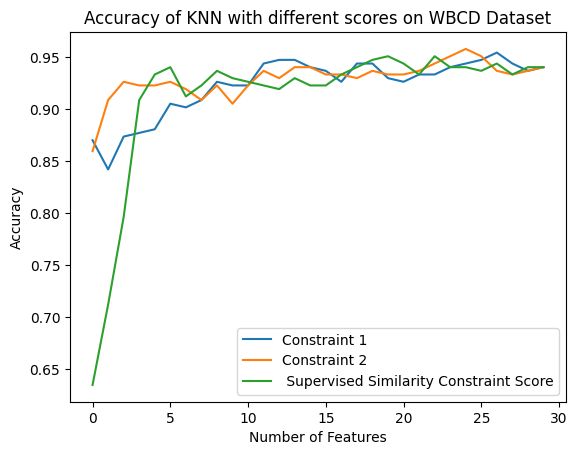

In [20]:
scores = [constraint_score_1,constraint_score_2,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_WBCD, X_test_WBCD,1,3)
accuracy_constraint_1 = scores_accuracy[0]
accuracy_constraint_2 = scores_accuracy[1]
accuracy_supervised_similarity_constraint = scores_accuracy[2]


plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_2, label = 'Constraint 2')
plt.plot(accuracy_supervised_similarity_constraint, label = ' Supervised Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on WBCD Dataset')

plt.legend()

In [21]:
auc_constraint_1 = auc_score(accuracy_constraint_1)
auc_constraint_2 = auc_score(accuracy_constraint_2)
auc_similarity_constraint = auc_score(accuracy_supervised_similarity_constraint)

print('AUC of Constraint 1: ', auc_constraint_1)
print('AUC of Constraint 2: ', auc_constraint_2)
print('AUC of Similarity Constraint Score: ', auc_similarity_constraint)

AUC of Constraint 1:  0.8928654970760235
AUC of Constraint 2:  0.8993567251461987
AUC of Similarity Constraint Score:  0.8853216374269006


Rep number: 100%|██████████| 1/1 [02:20<00:00, 140.90s/it]


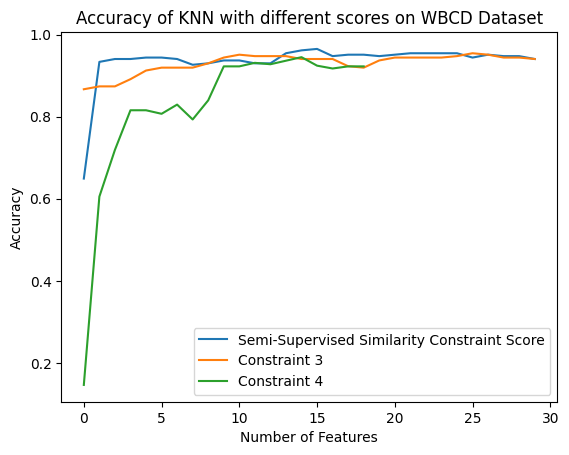

In [22]:
scores = [semi_supervised_similarity_constraint_score,constraint_score_3,constraint_score_4]
scores_accuracy = plot_accuracy(scores, X_train_WBCD, X_test_WBCD,1,3)
accuracy_semi_supervised_similarity_constraint = scores_accuracy[0]
accuracy_constraint_3 = scores_accuracy[1]



plt.plot(accuracy_semi_supervised_similarity_constraint, label = 'Semi-Supervised Similarity Constraint Score')
plt.plot(accuracy_constraint_3, label = 'Constraint 3')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on WBCD Dataset')

plt.legend()

In [23]:
auc_constraint_3 = auc_score(accuracy_constraint_3)
auc_constraint_4 = auc_score(accuracy_constraint_4)
auc_semi_similarity_constraint = auc_score(accuracy_semi_supervised_similarity_constraint)

print('AUC of Semi-Supervised Similarity Constraint Score: ', auc_semi_similarity_constraint)
print('AUC of Constraint 3: ', auc_constraint_3)
print('AUC of Constraint 4: ', auc_constraint_4)


AUC of Semi-Supervised Similarity Constraint Score:  0.9087134502923976
AUC of Constraint 3:  0.8998245614035087
AUC of Constraint 4:  0.7950998185117967


### Ionosphere Dataset

In [14]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
ionosphere = fetch_ucirepo(id=52)

# data (as pandas dataframes)
X = ionosphere.data.features
y = ionosphere.data.targets

X = X.values
y = y.values
le = LabelEncoder()
y = le.fit_transform(y)

data_ionosphere = np.concatenate((X,y[np.newaxis].T), axis=1)
X_train_ionosphere, X_test_ionosphere = split_dataset(data_ionosphere)

Rep number:   0%|          | 0/10 [00:00<?, ?it/s]

Rep number: 100%|██████████| 10/10 [05:06<00:00, 30.63s/it]


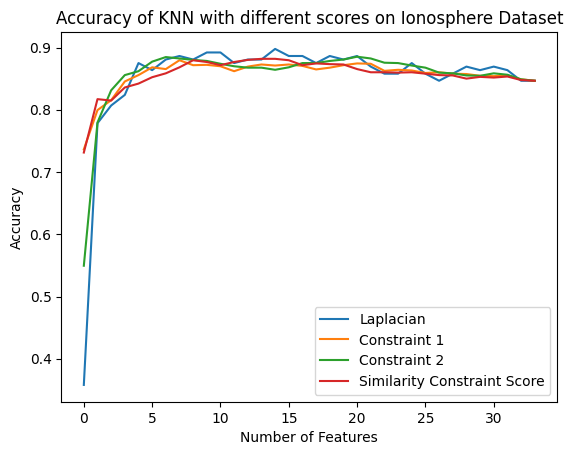

In [15]:
scores = [laplacian_score,constraint_score_1,constraint_score_2,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_ionosphere, X_test_ionosphere,10,3)
accuracy_laplacian = scores_accuracy[0]
accuracy_constraint_1 = scores_accuracy[1]
accuracy_constraint_2 = scores_accuracy[2]
accuracy_supervised_similarity_constraint = scores_accuracy[3]


plt.plot(accuracy_laplacian, label = 'Laplacian')
plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_2, label = 'Constraint 2')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Ionosphere Dataset')

plt.legend()

In [16]:
auc_laplacian = auc_score(accuracy_laplacian)
auc_constraint_1 = auc_score(accuracy_constraint_1)
auc_constraint_2 = auc_score(accuracy_constraint_2)
auc_similarity_constraint = auc_score(accuracy_supervised_similarity_constraint)

print('AUC of Laplacian: ', auc_laplacian)
print('AUC of Constraint 1: ', auc_constraint_1)
print('AUC of Constraint 2: ', auc_constraint_2)
print('AUC of Similarity Constraint Score: ', auc_similarity_constraint)

AUC of Laplacian:  0.8338903743315509
AUC of Constraint 1:  0.8335728609625668
AUC of Constraint 2:  0.8352356283422459
AUC of Similarity Constraint Score:  0.833163435828877


Rep number: 100%|██████████| 10/10 [05:39<00:00, 33.97s/it]


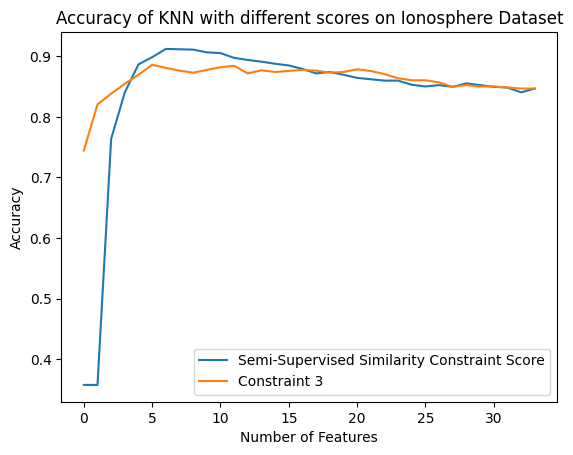

In [17]:
scores = [semi_supervised_similarity_constraint_score,constraint_score_3]
scores_accuracy = plot_accuracy(scores, X_train_ionosphere, X_test_ionosphere,10,3)
accuracy_semi_supervised_similarity_constraint = scores_accuracy[0]
accuracy_constraint_3 = scores_accuracy[1]



plt.plot(accuracy_semi_supervised_similarity_constraint, label = 'Semi-Supervised Similarity Constraint Score')
plt.plot(accuracy_constraint_3, label = 'Constraint 3')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Ionosphere Dataset')

plt.legend()

In [18]:
auc_constraint_3 = auc_score(accuracy_constraint_3)
auc_semi_similarity_constraint = auc_score(accuracy_semi_supervised_similarity_constraint)

print('AUC of Semi-Supervised Similarity Constraint Score: ', auc_semi_similarity_constraint)
print('AUC of Constraint 3: ', auc_constraint_3)

AUC of Semi-Supervised Similarity Constraint Score:  0.8216911764705882
AUC of Constraint 3:  0.8381183155080214


### Libras Movement

In [24]:
### Libras Movement
libras_movement = pd.read_csv('./sim_based_cs/data/libras.csv')
libras_movement.head()
# get the features and the target in numpy format
X = libras_movement.iloc[:, :-1].values
y = libras_movement.iloc[:,-1].values


data_libras = np.concatenate((X,y[np.newaxis].T), axis=1)
X_train_libras, X_test_libras = split_dataset(data_libras)

Rep number: 100%|██████████| 1/1 [06:30<00:00, 390.46s/it]


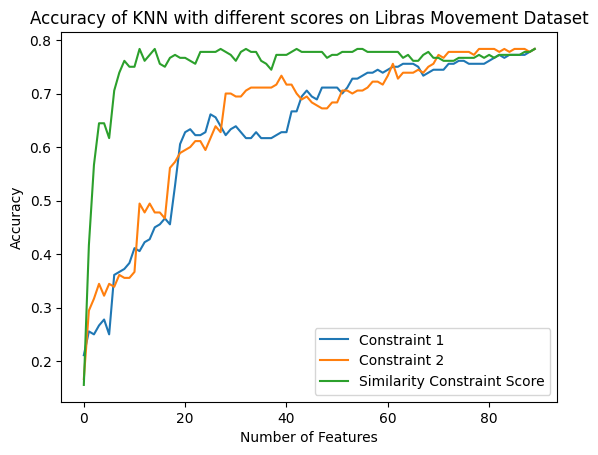

In [25]:
scores = [constraint_score_1,constraint_score_2,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_libras, X_test_libras,1,3)
accuracy_constraint_1 = scores_accuracy[0]
accuracy_constraint_2 = scores_accuracy[1]
accuracy_supervised_similarity_constraint = scores_accuracy[2]

plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_2, label = 'Constraint 2')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Libras Movement Dataset')

plt.legend()

In [27]:
print('AUC of Constraint 1: ', auc_score(accuracy_constraint_1))
print('AUC of Constraint 2: ', auc_score(accuracy_constraint_2))
print('AUC of Similarity Constraint Score: ', auc_score(accuracy_supervised_similarity_constraint))



AUC of Constraint 1:  0.6287345679012346
AUC of Constraint 2:  0.6454012345679013
AUC of Similarity Constraint Score:  0.7472530864197531


Rep number: 100%|██████████| 1/1 [07:58<00:00, 478.77s/it]


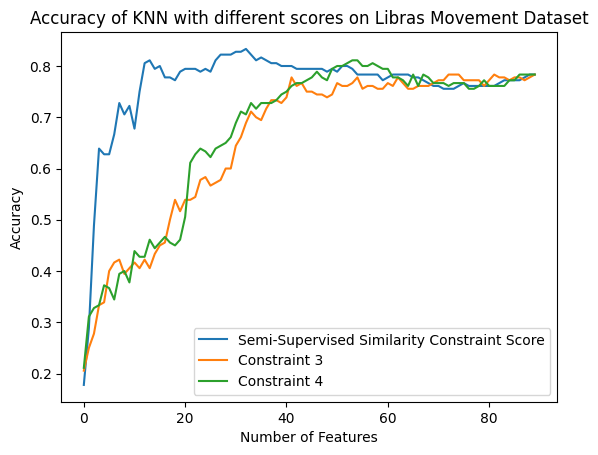

In [28]:
scores = [constraint_score_3,semi_supervised_similarity_constraint_score,constraint_score_4]
scores_accuracy = plot_accuracy(scores, X_train_libras, X_test_libras,1,3)
accuracy_constraint_3 = scores_accuracy[0]
accuracy_semi_supervised_similarity_constraint = scores_accuracy[1]
accuracy_constraint_4 = scores_accuracy[2]



plt.plot(accuracy_semi_supervised_similarity_constraint, label = 'Semi-Supervised Similarity Constraint Score')
plt.plot(accuracy_constraint_3, label = 'Constraint 3')
plt.plot(accuracy_constraint_4, label = 'Constraint 4')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on Libras Movement Dataset')

plt.legend()

In [29]:
auc_constraint_3 = auc_score(accuracy_constraint_3)
auc_constraint_4 = auc_score(accuracy_constraint_4)
auc_semi_similarity_constraint = auc_score(accuracy_semi_supervised_similarity_constraint)

print('AUC of Semi-Supervised Similarity Constraint Score: ', auc_semi_similarity_constraint)
print('AUC of Constraint 3: ', auc_constraint_3)
print('AUC of Constraint 4: ', auc_constraint_4)

AUC of Semi-Supervised Similarity Constraint Score:  0.756141975308642
AUC of Constraint 3:  0.6499382716049383
AUC of Constraint 4:  0.663858024691358


### CNAE-9 Dataset

In [3]:
### Libras Movement
cnae9_data = pd.read_csv('./sim_based_cs/data/cnae9.csv')
# get the features and the target in numpy format
X = cnae9_data.iloc[:, 1:].values
y = cnae9_data.iloc[:,0].values


cnae9_data = np.concatenate((X,y[np.newaxis].T), axis=1)
cnae9_data = cnae9_data.astype(float)
cnae9_reduced, _ = split_dataset(cnae9_data)
cnae9_reduced, _ = split_dataset(cnae9_reduced)

X_train_cnae9, X_test_cnae9 = split_dataset(cnae9_reduced)

Rep number: 100%|██████████| 1/1 [6:35:18<00:00, 23718.94s/it]


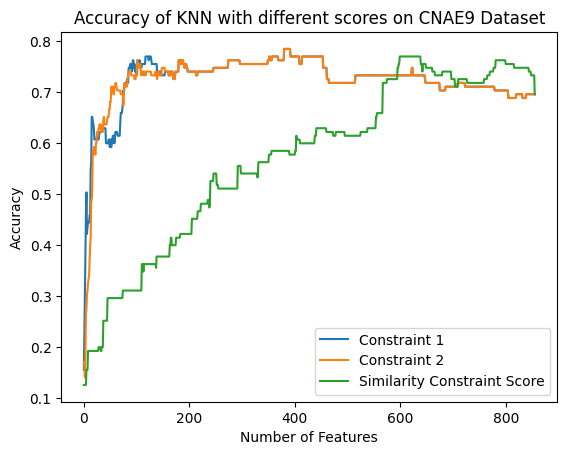

In [30]:
scores = [constraint_score_1,constraint_score_2,supervised_similarity_constraint_score]
scores_accuracy = plot_accuracy(scores, X_train_cnae9, X_test_cnae9,1,3)
accuracy_constraint_1 = scores_accuracy[0]
accuracy_constraint_2 = scores_accuracy[1]
accuracy_supervised_similarity_constraint = scores_accuracy[2]

plt.plot(accuracy_constraint_1, label = 'Constraint 1')
plt.plot(accuracy_constraint_2, label = 'Constraint 2')
plt.plot(accuracy_supervised_similarity_constraint, label = 'Similarity Constraint Score')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different scores on CNAE9 Dataset')

plt.legend()


$
SC_{r}^1 = \frac{\sum_{i=1}^n \sum_{j=1}^n (x_{ir} - x_{jr})^2 w_{ij}^{\mathcal{M}}}{\sum_{i=1}^n \sum_{j=1}^n (x_{ir} - x_{jr})^2 w_{ij}^{\mathcal{C}}} = \frac{f_{r}^T L^{\mathcal{M}} f_{r}^T}{f_{r}^T L^{\mathcal{C}} f_{r}^T}
$